**Pergunta-Guia: O Brasil é um país desigual?**



> Projeto do primeiro módulo da disciplina de estatística para ciência de dados. Composto pela equipe: Ana Caroline, Carlos Eduardo, Claudio Cruz, Julio Sousa e Maria Eduarda.
Nesse projeto analisamos e cruzamos os dados dos estados e munícipios do Nordeste.



# Importação e cruzamento dos dados

In [185]:

import pandas as pd

""" !gdown --id 1GQVxYHY9ouZvh_Jkbzt3sjnWHslxGqnX
!gdown --id 1OLg85S7vAr4MQomc_wcaQhRo6SLciSu0
!gdown --id 1G3Ll5LsIhsvpodjnKg6JE0KXbc_D-BSP

!gdown --id 1fTpyrtqqg4TiLXjNtaDqEfQmLRsHJ5A5 """



' !gdown --id 1GQVxYHY9ouZvh_Jkbzt3sjnWHslxGqnX\n!gdown --id 1OLg85S7vAr4MQomc_wcaQhRo6SLciSu0\n!gdown --id 1G3Ll5LsIhsvpodjnKg6JE0KXbc_D-BSP\n\n!gdown --id 1fTpyrtqqg4TiLXjNtaDqEfQmLRsHJ5A5 '

In [186]:
import geopandas as gpd

zip_path = "RG2017_regioesgeograficas2017_20180911.zip"

# o GeoPandas/Fiona suporta leitura direta com "zip://"
df_mun = gpd.read_file(f"zip://{zip_path}")


In [187]:
df_pib = pd.read_csv("tabela5938_2020.csv.xz")
df_pop = pd.read_csv("tabela6579_2020.csv.xz")
df_dtb = pd.read_csv("RELATORIO_DTB_BRASIL_MUNICIPIO.csv")

In [188]:
df_aux1 = pd.merge(df_pib,df_pop,how='outer',left_on='Cód.',right_on='Cód.')
df_aux1 = df_aux1.drop(columns=['Município_y'])

df_geral = pd.merge(df_aux1,df_dtb,how='left',left_on='Cód.',right_on='Código Município Completo')

uf_ne=['Alagoas','Bahia','Ceará','Maranhão','Paraíba','Pernambuco','Piauí','Rio Grande do Norte','Sergipe']
df_nordeste = df_geral[df_geral['Nome_UF'].isin(uf_ne)]

df_nordeste = df_nordeste.drop(columns=['Código Município Completo'])

# Cálculo de variáveis auxiliares

# Aplicação de medidas estatísticas

**Cálculo do PIB per capita dos municípios do Nordeste em reais**

In [189]:
df_nordeste['PIB per capita'] = (df_nordeste['PIB (Mil Reais)'] * 1000) / df_nordeste['População (Pessoas)']


# Trecho para analise do perfil estrutural dos tops/Bottons municipios

In [190]:

import numpy as np
import matplotlib.pyplot as plt

In [191]:
# Garantir que estamos trabalhando com uma cópia (opcional)
dfn = df_nordeste.copy()

# Filtrar linhas com PIB > 0 para evitar divisões problemáticas
dfn = dfn[dfn['PIB (Mil Reais)'] > 0].copy()

# Conferir se a coluna "PIB per capita" está numérica
dfn['PIB per capita'] = pd.to_numeric(dfn['PIB per capita'], errors='coerce')


In [192]:
# Participações relativas por setor (% do PIB municipal)
dfn['% Agro'] = (dfn['VA da agropecuária (Mil Reais)'] / dfn['PIB (Mil Reais)']) * 100
dfn['% Indústria'] = (dfn['VA da indústria (Mil Reais)'] / dfn['PIB (Mil Reais)']) * 100
dfn['% Serviços'] = (dfn['VA dos serviços (Mil Reais)'] / dfn['PIB (Mil Reais)']) * 100
dfn['% Adm Pública'] = (dfn['VA da administração pública (Mil Reais)'] / dfn['PIB (Mil Reais)']) * 100

# Opcional: HHI setorial (diversificação x concentração) — com shares em fração (0–1)
shares = np.vstack([
    (dfn['VA da agropecuária (Mil Reais)'] / dfn['PIB (Mil Reais)']).fillna(0).clip(0,1),
    (dfn['VA da indústria (Mil Reais)'] / dfn['PIB (Mil Reais)']).fillna(0).clip(0,1),
    (dfn['VA dos serviços (Mil Reais)'] / dfn['PIB (Mil Reais)']).fillna(0).clip(0,1),
    (dfn['VA da administração pública (Mil Reais)'] / dfn['PIB (Mil Reais)']).fillna(0).clip(0,1),
]).T
dfn['HHI_setorial'] = (shares**2).sum(axis=1)

In [193]:
# Pelo VA em valores absolutos:
setor_cols_val = [
    'VA da agropecuária (Mil Reais)',
    'VA da indústria (Mil Reais)',
    'VA dos serviços (Mil Reais)',
    'VA da administração pública (Mil Reais)'
]
dfn['Setor Predominante (VA)'] = dfn[setor_cols_val].idxmax(axis=1)

# Ou, se preferir, pelo % do PIB (dá na mesma na prática):
setor_cols_perc = ['% Agro', '% Indústria', '% Serviços', '% Adm Pública']
dfn['Setor Predominante (%)'] = dfn[setor_cols_perc].idxmax(axis=1)

# Distribuição geral (contagem)
pred_count = dfn['Setor Predominante (%)'].value_counts()
print(pred_count)

Setor Predominante (%)
% Adm Pública    1313
% Serviços        272
% Agro            127
% Indústria        82
Name: count, dtype: int64


In [194]:
# Definição de TOP e BOTTOM por percentis de PIB per capita

# Ex.: Top 5% mais ricos e Bottom 5% mais pobres em PIB per capita
q_top = dfn['PIB per capita'].quantile(0.95)
q_bot = dfn['PIB per capita'].quantile(0.05)

top = dfn[dfn['PIB per capita'] >= q_top].copy()
bot = dfn[dfn['PIB per capita'] <= q_bot].copy()

len(top), len(bot), dfn.shape[0]
TOP_K = 100
BOT_K = 100
top_k = dfn.sort_values('PIB per capita', ascending=False).head(TOP_K).copy()
bot_k = dfn.sort_values('PIB per capita', ascending=True).head(BOT_K).copy()

In [195]:
# Perfis setoriais dos extremos (TOP x BOTTOM) e do GERAL

def perfil_setorial(df_):
    return pd.Series({
        'Agro (%)': df_['% Agro'].mean(),
        'Indústria (%)': df_['% Indústria'].mean(),
        'Serviços (%)': df_['% Serviços'].mean(),
        'Adm Pública (%)': df_['% Adm Pública'].mean(),
        'HHI médio': df_['HHI_setorial'].mean(),
        'PIB pc médio (R$)': df_['PIB per capita'].mean(),
        'PIB pc mediano (R$)': df_['PIB per capita'].median(),
        'N municípios': len(df_)
    })

perfil_top = perfil_setorial(top)
perfil_bot = perfil_setorial(bot)
perfil_all = perfil_setorial(dfn)

perf_is = pd.DataFrame([perfil_top, perfil_bot, perfil_all], index=['TOP (≥95%)','BOTTOM (≤5%)','GERAL'])

Leitura esperada:

TOP: % Indústria e % Serviços maiores, % Adm Pública menor, HHI pode ser alto (quando um setor domina), mas normalmente com base privada.

BOTTOM: % Adm Pública alto, agro relevante, PIB pc baixo; HHI alto indica dependência de 1 setor.

In [196]:
def contagem_predominante(df_):
    cont = df_['Setor Predominante (%)'].value_counts().reindex(['% Indústria','% Serviços','% Agro','% Adm Pública'])
    return cont.fillna(0).astype(int)

cont_top = contagem_predominante(top).rename('TOP (≥95%)')
cont_bot = contagem_predominante(bot).rename('BOTTOM (≤5%)')
cont_all = contagem_predominante(dfn).rename('GERAL')

pred_resumo = pd.concat([cont_top, cont_bot, cont_all], axis=1)

<Figure size 640x480 with 0 Axes>

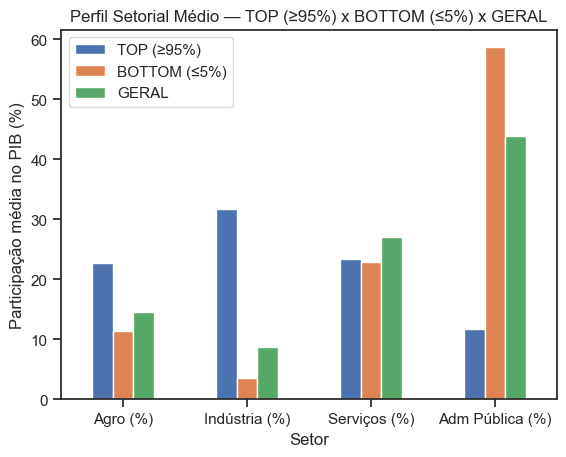

In [197]:
# Gráficos comparando perfis

# Tabela só com os 4 setores (%)
plot_df = perf_is[['Agro (%)','Indústria (%)','Serviços (%)','Adm Pública (%)']].copy()

plt.figure()
plot_df.T.plot(kind='bar')
plt.title('Perfil Setorial Médio — TOP (≥95%) x BOTTOM (≤5%) x GERAL')
plt.xlabel('Setor')
plt.ylabel('Participação média no PIB (%)')
plt.xticks(rotation=0)
plt.legend(title='')
plt.show()

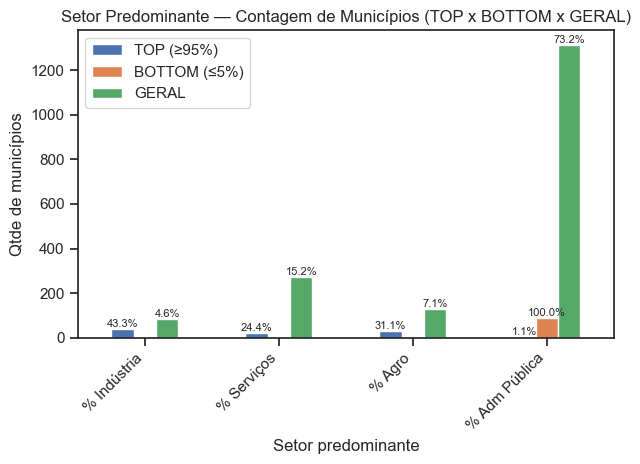

In [198]:
# Plot básico
ax = pred_resumo.plot(kind='bar')
plt.title('Setor Predominante — Contagem de Municípios (TOP x BOTTOM x GERAL)')
plt.xlabel('Setor predominante')
plt.ylabel('Qtde de municípios')
plt.xticks(rotation=45, ha='right')
plt.legend(title='')
plt.tight_layout()

# Adicionar rótulos com percentual
for container, col in zip(ax.containers, pred_resumo.columns):
    total = pred_resumo[col].sum()
    for bar in container:
        height = bar.get_height()
        if height > 0:
            perc = (height / total) * 100
            ax.text(
                bar.get_x() + bar.get_width() / 2,   # posição x central
                height,                              # posição y logo acima da barra
                f'{perc:.1f}%',                      # formatação percentual
                ha='center', va='bottom', fontsize=8
            )

plt.show()

In [199]:
# Listas dos casos extremos (para “dar nome aos bois” no relatório)

# TOP 15 com setor predominante e %Adm
cols_show = ['Nome_UF','Nome_Município','PIB per capita','% Agro','% Indústria','% Serviços','% Adm Pública','Setor Predominante (%)']
top_list = dfn.sort_values('PIB per capita', ascending=False).head(15)[cols_show]
bot_list = dfn.sort_values('PIB per capita', ascending=True).head(15)[cols_show]


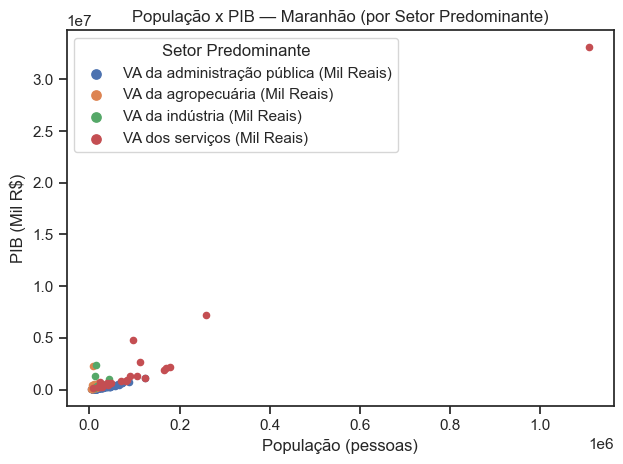

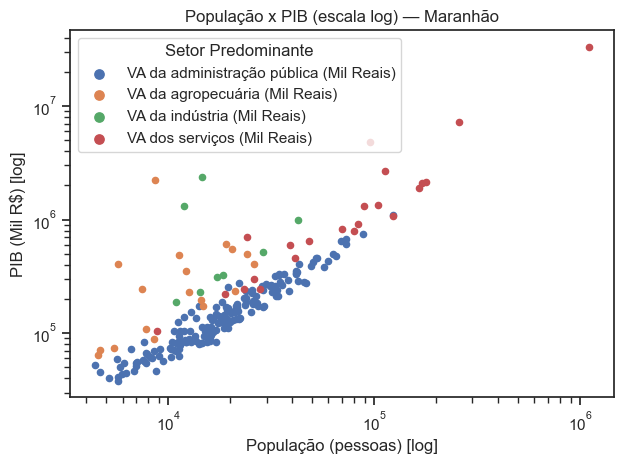

In [200]:

# Copia do dataset
dfn = df_nordeste.copy()

# Filtro para um estado (ex.: Bahia)
estado = "Maranhão"
df_estado = dfn[dfn["Nome_UF"] == estado].copy()

# Garante que os valores sejam numéricos
num_cols = [
    'PIB (Mil Reais)', 'População (Pessoas)',
    'VA da agropecuária (Mil Reais)', 'VA da indústria (Mil Reais)',
    'VA dos serviços (Mil Reais)', 'VA da administração pública (Mil Reais)'
]
for c in num_cols:
    df_estado[c] = pd.to_numeric(df_estado[c], errors='coerce')

# Se ainda não tiver coluna de setor predominante, calcula
setor_cols = [
    'VA da agropecuária (Mil Reais)',
    'VA da indústria (Mil Reais)',
    'VA dos serviços (Mil Reais)',
    'VA da administração pública (Mil Reais)'
]
if 'Setor Predominante (VA)' not in df_estado.columns:
    df_estado['Setor Predominante (VA)'] = df_estado[setor_cols].idxmax(axis=1)

# Prepara o dataset
plot_df = df_estado[['População (Pessoas)', 'PIB (Mil Reais)', 'Setor Predominante (VA)']].dropna()

# --- Gráfico linear ---
plt.figure()
for cat in sorted(plot_df['Setor Predominante (VA)'].unique()):
    sub = plot_df[plot_df['Setor Predominante (VA)'] == cat]
    plt.scatter(sub['População (Pessoas)'], sub['PIB (Mil Reais)'], label=cat, s=20)

plt.title(f'População x PIB — {estado} (por Setor Predominante)')
plt.xlabel('População (pessoas)')
plt.ylabel('PIB (Mil R$)')
plt.legend(title='Setor Predominante', markerscale=1.5)
plt.tight_layout()
plt.show()

# --- Gráfico em escala log ---
plt.figure()
for cat in sorted(plot_df['Setor Predominante (VA)'].unique()):
    sub = plot_df[plot_df['Setor Predominante (VA)'] == cat]
    plt.scatter(sub['População (Pessoas)'], sub['PIB (Mil Reais)'], label=cat, s=20)

plt.xscale('log')
plt.yscale('log')
plt.title(f'População x PIB (escala log) — {estado}')
plt.xlabel('População (pessoas) [log]')
plt.ylabel('PIB (Mil R$) [log]')
plt.legend(title='Setor Predominante', markerscale=1.5)
plt.tight_layout()
plt.show()



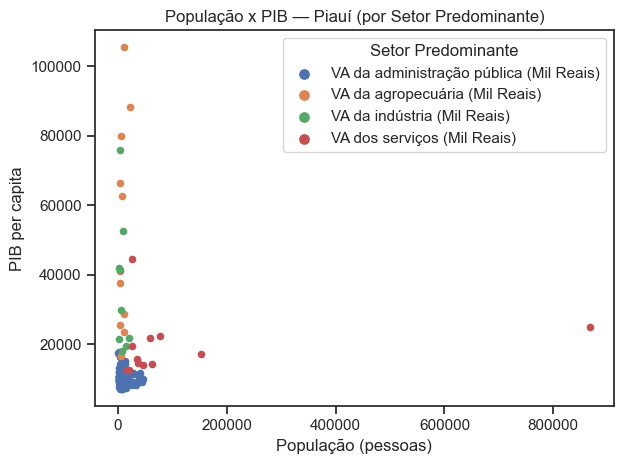

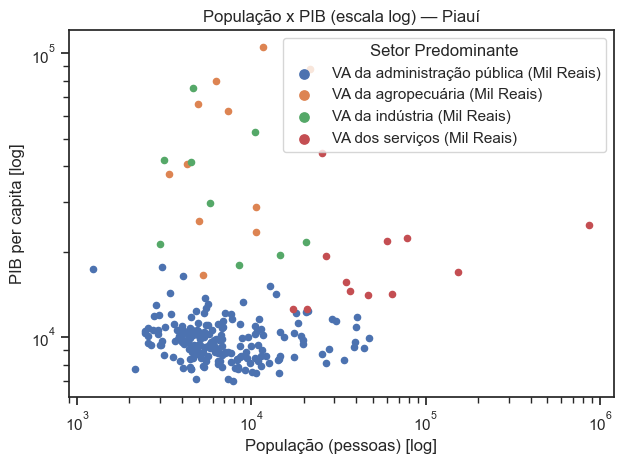

In [201]:

# Copia do dataset
dfn = df_nordeste.copy()

# Filtro para um estado (ex.: Bahia)
estado = "Piauí"
df_estado = dfn[dfn["Nome_UF"] == estado].copy()

# Garante que os valores sejam numéricos
num_cols = [
    'PIB per capita', 'População (Pessoas)',
    'VA da agropecuária (Mil Reais)', 'VA da indústria (Mil Reais)',
    'VA dos serviços (Mil Reais)', 'VA da administração pública (Mil Reais)'
]
for c in num_cols:
    df_estado[c] = pd.to_numeric(df_estado[c], errors='coerce')

# Se ainda não tiver coluna de setor predominante, calcula
setor_cols = [
    'VA da agropecuária (Mil Reais)',
    'VA da indústria (Mil Reais)',
    'VA dos serviços (Mil Reais)',
    'VA da administração pública (Mil Reais)'
]
if 'Setor Predominante (VA)' not in df_estado.columns:
    df_estado['Setor Predominante (VA)'] = df_estado[setor_cols].idxmax(axis=1)

# Prepara o dataset
plot_df = df_estado[['População (Pessoas)', 'PIB per capita', 'Setor Predominante (VA)']].dropna()

# --- Gráfico linear ---
plt.figure()
for cat in sorted(plot_df['Setor Predominante (VA)'].unique()):
    sub = plot_df[plot_df['Setor Predominante (VA)'] == cat]
    plt.scatter(sub['População (Pessoas)'], sub['PIB per capita'], label=cat, s=20)

plt.title(f'População x PIB — {estado} (por Setor Predominante)')
plt.xlabel('População (pessoas)')
plt.ylabel('PIB per capita')
plt.legend(title='Setor Predominante', markerscale=1.5)
plt.tight_layout()
plt.show()

# --- Gráfico em escala log ---
plt.figure()
for cat in sorted(plot_df['Setor Predominante (VA)'].unique()):
    sub = plot_df[plot_df['Setor Predominante (VA)'] == cat]
    plt.scatter(sub['População (Pessoas)'], sub['PIB per capita'], label=cat, s=20)

plt.xscale('log')
plt.yscale('log')
plt.title(f'População x PIB (escala log) — {estado}')
plt.xlabel('População (pessoas) [log]')
plt.ylabel('PIB per capita [log]')
plt.legend(title='Setor Predominante', markerscale=1.5)
plt.tight_layout()
plt.show()


## mapa de correlação (heatmap da matriz de correlação)

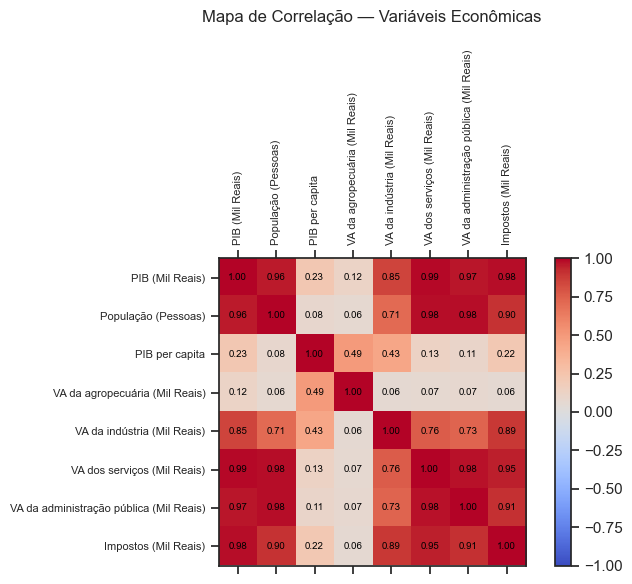

In [202]:

# Seleciona apenas colunas numéricas de interesse
cols_corr = [
    'PIB (Mil Reais)', 'População (Pessoas)', 'PIB per capita',
    'VA da agropecuária (Mil Reais)', 'VA da indústria (Mil Reais)',
    'VA dos serviços (Mil Reais)', 'VA da administração pública (Mil Reais)',
    'Impostos (Mil Reais)'
]
corr = df_nordeste[cols_corr].corr()

# Plot do mapa de correlação
fig, ax = plt.subplots(figsize=(8,6))
cax = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)

# Adiciona barra de cores
fig.colorbar(cax)

# Eixos
ax.set_xticks(range(len(cols_corr)))
ax.set_yticks(range(len(cols_corr)))
ax.set_xticklabels(cols_corr, rotation=90, fontsize=8)
ax.set_yticklabels(cols_corr, fontsize=8)

# Adiciona os valores de correlação na matriz
for (i, j), val in np.ndenumerate(corr.values):
    ax.text(j, i, f"{val:.2f}", ha='center', va='center', color='black', fontsize=7)

plt.title("Mapa de Correlação — Variáveis Econômicas", pad=20)
plt.tight_layout()
plt.show()


Correlação por estado

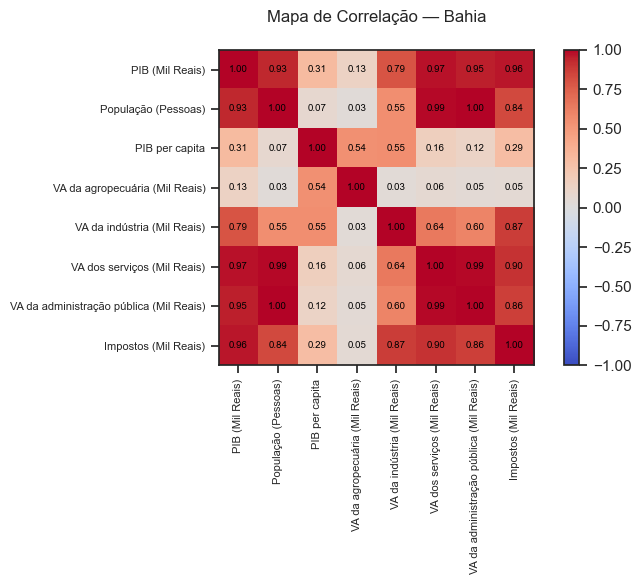

In [203]:

# --- Defina aqui o estado desejado ---
estado = "Bahia"   # troque para "Pernambuco", "Ceará", etc.

# Filtra os dados do estado
df_estado = df_nordeste[df_nordeste["Nome_UF"] == estado].copy()

# Seleciona apenas colunas numéricas de interesse
cols_corr = [
    'PIB (Mil Reais)', 'População (Pessoas)', 'PIB per capita',
    'VA da agropecuária (Mil Reais)', 'VA da indústria (Mil Reais)',
    'VA dos serviços (Mil Reais)', 'VA da administração pública (Mil Reais)',
    'Impostos (Mil Reais)'
]
corr = df_estado[cols_corr].corr()

# Plot do mapa de correlação
fig, ax = plt.subplots(figsize=(8,6))
cax = ax.imshow(
    corr, 
    cmap='coolwarm', 
    vmin=-1, vmax=1, 
    aspect="equal", 
    interpolation="nearest"   # evita linhas artificiais
)

fig.colorbar(cax)

# Eixos
ax.set_xticks(range(len(cols_corr)))
ax.set_yticks(range(len(cols_corr)))
ax.set_xticklabels(cols_corr, rotation=90, fontsize=8)
ax.set_yticklabels(cols_corr, fontsize=8)

# Valores na matriz
for (i, j), val in np.ndenumerate(corr.values):
    ax.text(j, i, f"{val:.2f}", ha='center', va='center', color='black', fontsize=7)

plt.title(f"Mapa de Correlação — {estado}", pad=20)
plt.tight_layout()
plt.show()


JOIN com o mapa

In [204]:

#df_mun
 #Cód.
# CD_GEOCODI

df_nordeste_cm = df_nordeste.copy()

df_nordeste["Cód."] = df_nordeste["Cód."].astype(int)
df_mun["CD_GEOCODI"] = df_mun["CD_GEOCODI"].astype(int)

df_nordeste_cm = df_nordeste.merge(
    df_mun[["CD_GEOCODI", "geometry"]],   # pega só as colunas necessárias
    left_on="Cód.",
    right_on="CD_GEOCODI",
    how="inner"
)

# Recria como GeoDataFrame
df_nordeste_cm = gpd.GeoDataFrame(df_nordeste_cm, geometry="geometry", crs=df_mun.crs)
df_mun['UF'] = (df_nordeste_cm['Cód.'].astype(int)/10000).astype(int)

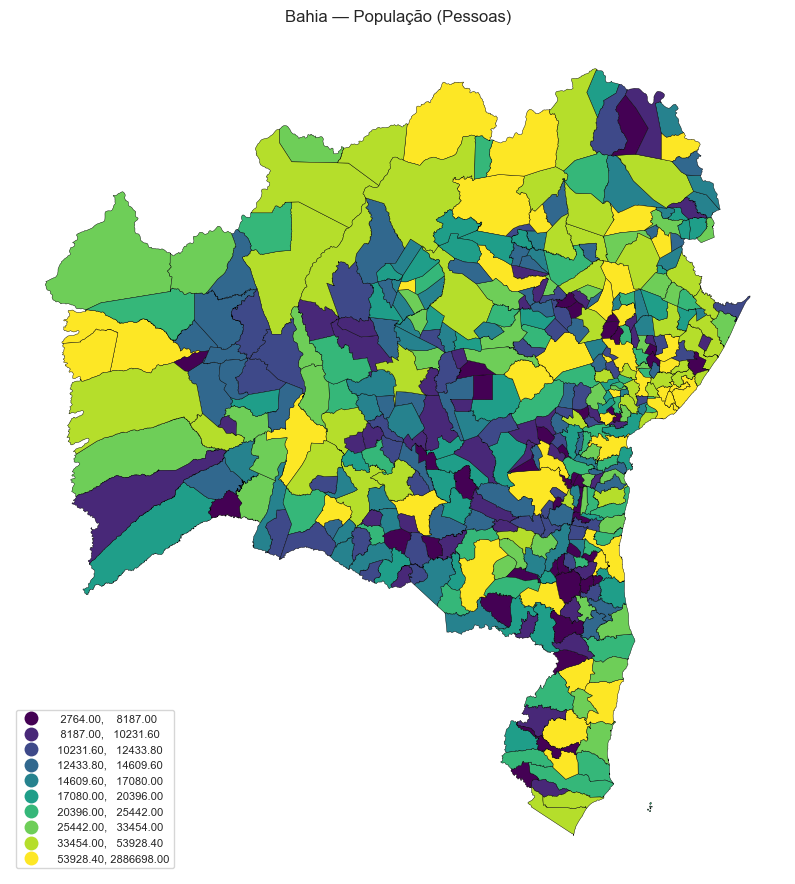

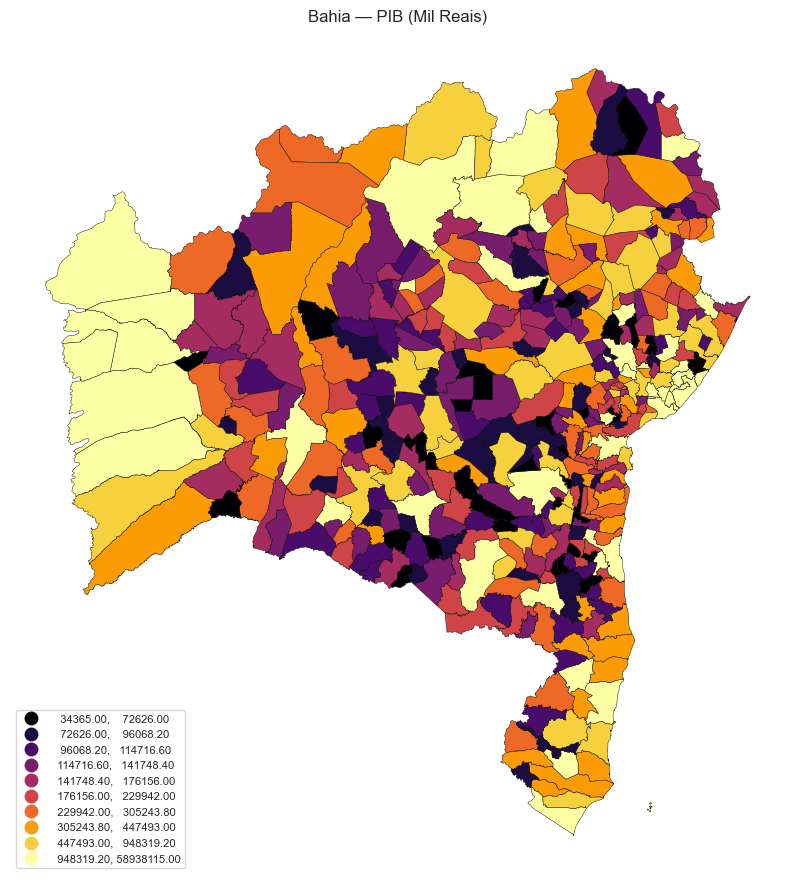

In [205]:
estado = "Bahia"

# 1) Filtrar Bahia (use a coluna que você tiver: 'uf' == 'BA' ou 'Nome_UF' == 'Bahia')
gdf_ba = df_nordeste_cm[df_nordeste_cm['UF'].eq(estado) | df_nordeste_cm['Nome_UF'].eq(estado)]

# 2) Garantir que é GeoDataFrame e herdar o CRS do original
gdf_ba = gpd.GeoDataFrame(gdf_ba, geometry='geometry', crs=df_nordeste_cm.crs)

# 3) Escolher a métrica de cor:
#    - Total do PIB (em "Mil Reais"): 'PIB (Mil Reais)'
#    - Ou PIB per capita: 'PIB per capita'
coluna_pib = 'População (Pessoas)'          # troque para 'PIB per capita' se preferir

# 4) Plot (com classes e legenda):
ax = gdf_ba.plot(
    column=coluna_pib,
    cmap='viridis',
    scheme='Quantiles',
    k=10,
    linewidth=0.3,
    edgecolor='black',
    legend=True,
    figsize=(9, 9),
    legend_kwds={
        "loc": "lower left",   # pode ser 'upper right', 'center left', etc.
        "fontsize": 8
    }
)
plt.subplots_adjust(right=0.85)

ax.set_title(f'{estado} — {coluna_pib}', fontsize=12)
ax.set_axis_off()
plt.tight_layout()
plt.show()

coluna_pib = 'PIB (Mil Reais)'          # troque para 'PIB per capita' se preferir

# 4) Plot (com classes e legenda):
ax = gdf_ba.plot(
    column=coluna_pib,
    cmap='inferno',
    scheme='Quantiles',
    k=10,
    linewidth=0.3,
    edgecolor='black',
    legend=True,
    figsize=(9, 9),
    legend_kwds={
        "loc": "lower left",   # pode ser 'upper right', 'center left', etc.
        "fontsize": 8
    }
)
plt.subplots_adjust(right=0.85)

ax.set_title(f'{estado} — {coluna_pib}', fontsize=12)
ax.set_axis_off()
plt.tight_layout()
plt.show()

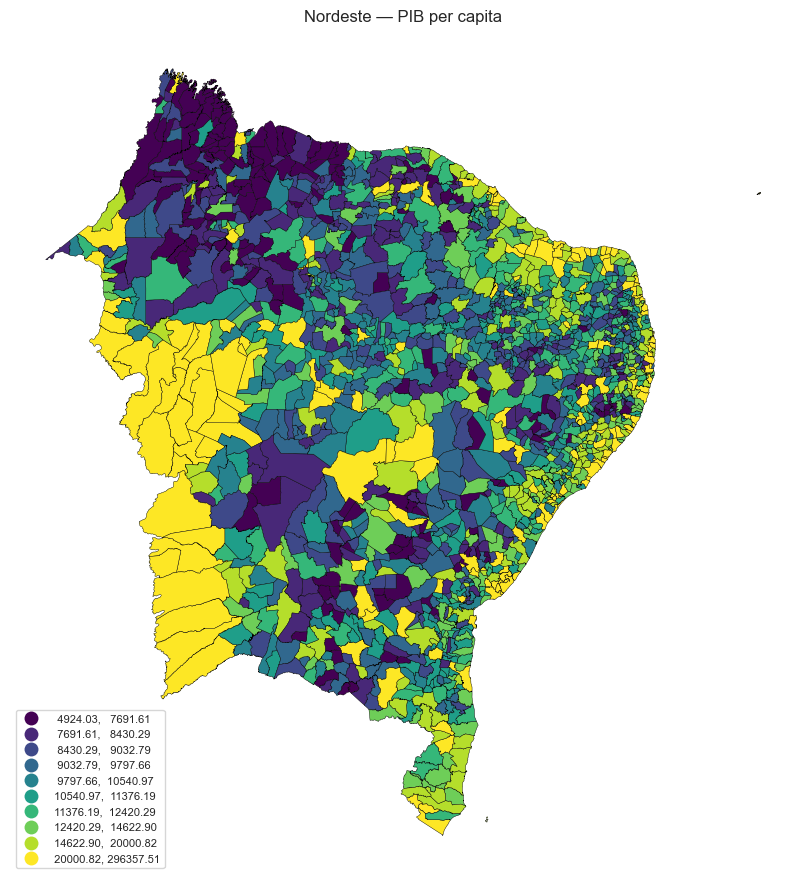

In [206]:

# 1) Filtrar Bahia (use a coluna que você tiver: 'uf' == 'BA' ou 'Nome_UF' == 'Bahia')
gdf_ba = df_nordeste_cm

# 2) Garantir que é GeoDataFrame e herdar o CRS do original
gdf_ba = gpd.GeoDataFrame(gdf_ba, geometry='geometry', crs=df_nordeste_cm.crs)

# 3) Escolher a métrica de cor:
#    - Total do PIB (em "Mil Reais"): 'PIB (Mil Reais)'
#    - Ou PIB per capita: 'PIB per capita'
coluna_pib = 'PIB per capita'          # troque para 'PIB per capita' se preferir

# 4) Plot (com classes e legenda):
ax = gdf_ba.plot(
    column=coluna_pib,
    cmap='viridis',
    scheme='Quantiles',
    k=10,
    linewidth=0.3,
    edgecolor='black',
    legend=True,
    figsize=(9, 9),
    legend_kwds={
        "loc": "lower left",   # pode ser 'upper right', 'center left', etc.
        "fontsize": 8
    }
)
plt.subplots_adjust(right=0.85)

ax.set_title(f'Nordeste — {coluna_pib}', fontsize=12)
ax.set_axis_off()
plt.tight_layout()
plt.show()

C:\Users\carlo\AppData\Local\Temp\ipykernel_18748\1291790031.py:91: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  gdf_estados.loc[gdf_estados[COL_UF].eq('BA')].boundary.plot(


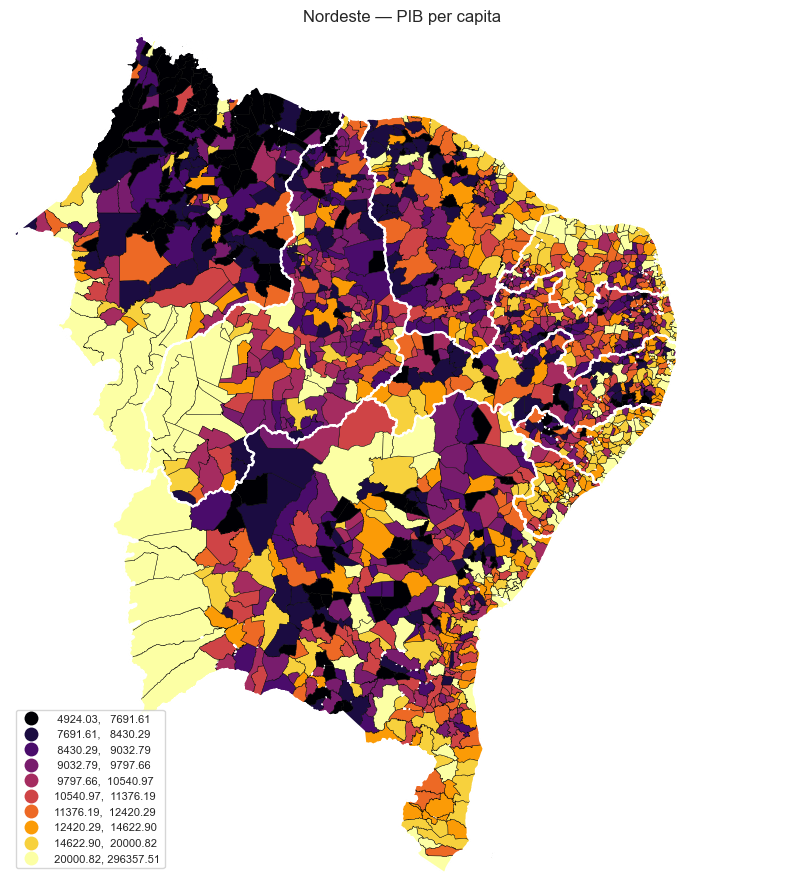

In [207]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# =========================
# Configurações de entrada
# =========================
#coluna = 'População (Pessoas)'
#coluna = 'PIB (Mil Reais)'
coluna = 'PIB per capita'


# =========================
# Preparação segura do dado
# =========================
gdf_ba = gpd.GeoDataFrame(df_nordeste_cm, geometry='geometry', crs=getattr(df_nordeste_cm, 'crs', None)).copy()

# Nome da coluna de UF: padronize aqui
COL_UF = 'UF'  # <-- ajuste para 'UF' se seu dataframe usa maiúsculas

if COL_UF not in gdf_ba.columns:
    raise KeyError(f"Coluna de UF '{COL_UF}' não encontrada. Colunas disponíveis: {list(gdf_ba.columns)}")

# Limpa geometrias problemáticas
gdf_ba = gdf_ba[gdf_ba.geometry.notna() & ~gdf_ba.geometry.is_empty].copy()

# Corrige geometrias inválidas
if hasattr(gdf_ba.geometry, "make_valid"):
    gdf_ba["geometry"] = gdf_ba.geometry.make_valid()
else:
    gdf_ba["geometry"] = gdf_ba.buffer(0)

# Coerção numérica
vals = pd.to_numeric(gdf_ba[coluna], errors="coerce").replace([np.inf, -np.inf], np.nan)
gdf_ba = gdf_ba[vals.notna()].copy()

# Se ainda vazio, pare cedo
if gdf_ba.empty:
    raise ValueError("Depois das coerções, não restou nenhum município com valor numérico para a coluna escolhida.")

# Define CRS caso esteja ausente e reprojeta para métrico (recomendado p/ plot estável)
if gdf_ba.crs is None:
    # suposição comum: dados em 4674; ajuste se necessário
    gdf_ba.set_crs(epsg=4674, inplace=True)

gdf_ba = gdf_ba.to_crs(3857)  # Web Mercator deixa os limites em metros e estáveis

# Bounds válidos?
xmin, ymin, xmax, ymax = gdf_ba.total_bounds
if not np.isfinite([xmin, ymin, xmax, ymax]).all() or xmin == xmax or ymin == ymax:
    raise ValueError("Limites espaciais inválidos mesmo após reprojeção. Verifique CRS/geometrias.")

# =========================
# Dissolve por estado
# =========================
gdf_estados = gdf_ba[[COL_UF, 'geometry']].dissolve(by=COL_UF, as_index=False)

if gdf_estados.empty:
    raise ValueError("O dissolve por UF não retornou geometrias. Verifique a coluna de UF e os dados.")

# =========================
# Plot
# =========================
fig, ax = plt.subplots(figsize=(9, 9))

# Defina os limites explicitamente antes do plot (ajuda o Matplotlib)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Force 'auto' primeiro (evita o erro de aspecto)
ax.set_aspect('auto')

# Choropleth
gdf_ba.plot(
    column=coluna,
    cmap='inferno',
    scheme='Quantiles',  # requer mapclassify; remova se não quiser classes
    k=10,
    linewidth=0.3,
    edgecolor='black',
    legend=True,
    ax=ax,
    legend_kwds={"loc": "lower left", "fontsize": 8}
)

# Contorno dos estados (use a mesma coluna de UF)
gdf_estados.boundary.plot(ax=ax, color='white', linewidth=1.5, zorder=3)

# Exemplo: destacar BA (ajuste o código conforme COL_UF)
gdf_estados.loc[gdf_estados[COL_UF].eq('BA')].boundary.plot(
    ax=ax, color='red', linewidth=2.2, zorder=4
)

ax.set_title(f'Nordeste — {coluna}', fontsize=12)
ax.set_axis_off()
plt.tight_layout()
plt.show()


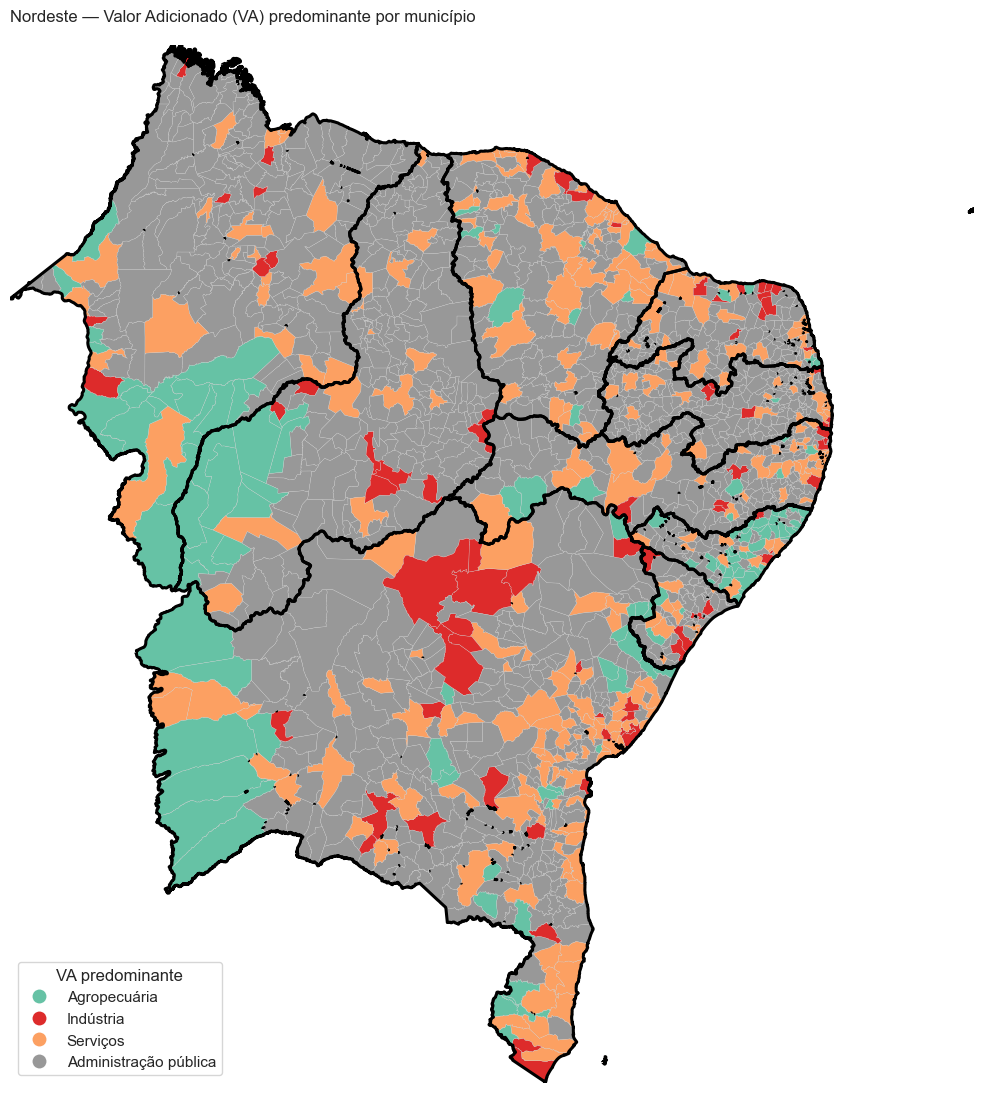

In [208]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# =========================
# 1) Base: seu GeoDataFrame
# =========================
gdf = gpd.GeoDataFrame(df_nordeste_cm, geometry='geometry', crs=getattr(df_nordeste_cm, 'crs', None)).copy()

# Colunas de Valor Adicionado
COLS_VA = [
    'VA da agropecuária (Mil Reais)',
    'VA da indústria (Mil Reais)',
    'VA dos serviços (Mil Reais)',
    'VA da administração pública (Mil Reais)',
]

# Conferências rápidas
for c in COLS_VA + ['UF', 'geometry']:
    if c not in gdf.columns:
        raise KeyError(f"Coluna obrigatória ausente: {c}")

# =========================
# 2) Limpeza e CRS
# =========================
gdf = gdf[gdf.geometry.notna() & ~gdf.geometry.is_empty].copy()

# Corrigir geometrias inválidas
if hasattr(gdf.geometry, "make_valid"):
    gdf['geometry'] = gdf.geometry.make_valid()
else:
    gdf['geometry'] = gdf.buffer(0)

# Definir CRS se vier sem
if gdf.crs is None:
    gdf = gdf.set_crs(epsg=4674)

# Reprojetar para 3857 (plot estável)
gdf = gdf.to_crs(3857)

# =========================
# 3) VA predominante
# =========================
for c in COLS_VA:
    gdf[c] = pd.to_numeric(gdf[c], errors='coerce')

idx = gdf[COLS_VA].idxmax(axis=1)

MAP_RÓTULO = {
    'VA da agropecuária (Mil Reais)': 'Agropecuária',
    'VA da indústria (Mil Reais)': 'Indústria',
    'VA dos serviços (Mil Reais)': 'Serviços',
    'VA da administração pública (Mil Reais)': 'Administração pública',
}
gdf['VA_predominante'] = idx.map(MAP_RÓTULO)

ordem = ['Agropecuária', 'Indústria', 'Serviços', 'Administração pública']
gdf['VA_predominante'] = pd.Categorical(gdf['VA_predominante'], categories=ordem, ordered=True)

# Paleta fixa
cores = {
    'Agropecuária':        '#66c2a5',
    'Indústria':           '#dd2b2b',
    'Serviços':            "#fca062",
    'Administração pública':"#989898",
}
cmap = ListedColormap([cores[c] for c in ordem])

# =========================
# 4) Polígonos dos estados
# =========================
estados = gdf[['UF', 'geometry']].dissolve(by='UF', as_index=False)

# =========================
# 5) Plot
# =========================
xmin, ymin, xmax, ymax = gdf.total_bounds
fig, ax = plt.subplots(figsize=(10, 12))

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_aspect('auto')

# Mapa categórico com legenda automática
gdf.plot(
    ax=ax,
    column='VA_predominante',
    categorical=True,
    cmap=cmap,
    legend=True,
    legend_kwds={'loc': 'lower left', 'title': 'VA predominante'},
    linewidth=0.2,
    edgecolor='#cccccc'
)

# Contorno grosso dos estados
estados.boundary.plot(ax=ax, linewidth=2.2, color='black', zorder=3)

ax.set_title('Nordeste — Valor Adicionado (VA) predominante por município', loc='left', fontsize=12)
ax.set_axis_off()
plt.tight_layout()
plt.show()



# Fim da analise de perfil

In [209]:
df_nordeste_teste = df_nordeste.groupby(['Nome_UF'])['PIB per capita']

In [210]:
df_nordeste_teste = df_nordeste.groupby(['Nome_UF'])['PIB per capita'].describe()
df_nordeste_teste['coef_variacao'] = ((df_nordeste_teste['std']/df_nordeste_teste['mean']) *100).round(2)
df_nordeste_teste = df_nordeste_teste.sort_values(by='coef_variacao',ascending=False)
df_nordeste_teste

,count,mean,std,min,25%,50%,75%,max,coef_variacao
Nome_UF,,,,,,,,,
Maranhão,217.0,12469.984085,22230.900674,4924.029824,6985.610552,8022.925095,10454.239092,260020.624563,178.28
Bahia,417.0,14718.686529,19782.901746,6217.444797,8621.412037,10636.552201,13704.371851,296357.510250,134.41
Rio Grande do Norte,167.0,17312.085158,19136.145405,8069.878345,10351.992622,12115.608108,16190.413387,153580.787633,110.54
Pernambuco,185.0,13597.080376,13406.616301,6517.159309,8569.627836,10605.875153,13537.371103,139391.956506,98.60
Piauí,224.0,13484.865672,12936.916976,7026.198652,8827.227429,9904.479783,11604.744722,105367.320709,95.94
Alagoas,102.0,16874.788528,14253.248997,6958.093673,10540.480132,13385.047324,18673.473587,129102.648077,84.46
Sergipe,75.0,16220.558406,11509.882723,9318.468702,11549.530207,13627.631157,16802.895309,103993.289915,70.96
Paraíba,223.0,11685.011823,7840.521714,7340.892330,8970.610615,10199.226306,11729.765515,111427.130329,67.10
Ceará,184.0,12504.510638,8043.999133,6695.223037,8673.445125,10444.428185,13215.399689,83473.122020,64.33


**Nota**: o Coeficiente de variação (CV) é a razão entre desvio padrão e média, expressa em %, e serve para comparar a variabilidade relativa, importante para entender desigualdade nesse contexto.

**Análise**: Os estados Coeficiente de variação mais alto têm desigualdade maior entre seus municípios. 
Sendo o top 5: Maranhão, Bahia, Rio Grande do Norte, Pernambuco e Piauí. 

In [211]:
estados_desiguais = ['Maranhão', 'Bahia', 'Rio Grande do Norte']
df_desiguais = df_nordeste[df_nordeste['Nome_UF'].isin(estados_desiguais)].sort_values(by='PIB per capita', ascending=False)


In [212]:
import pandas as pd

# Estados mais desiguais
estados_desiguais = ['Maranhão', 'Bahia', 'Rio Grande do Norte']

# Lista para armazenar os resultados
resultados = []

for estado in estados_desiguais:
    # Filtra só o estado
    df_estado = df_nordeste[df_nordeste['Nome_UF'] == estado]
    
    # Calcula a média do estado
    media_estado = df_estado['PIB per capita'].mean()
    
    # Pega os top 5 municípios por PIB per capita
    top_municipios = df_estado.sort_values(by='PIB per capita', ascending=False).head(5)
    
    # Adiciona ao resultado
    for _, row in top_municipios.iterrows():
        resultados.append({
            'Estado': estado,
            'Município': row['Nome_Município'],
            'PIB per capita': row['PIB per capita'],
            'Média do estado': media_estado,
            'Acima da média (%)': round(((row['PIB per capita'] - media_estado) / media_estado) * 100, 2)
        })

# Converte para DataFrame
df_top = pd.DataFrame(resultados)

# Mostra o resultado ordenado por estado e PIB
df_top = df_top.sort_values(by=['Estado', 'PIB per capita'], ascending=[True, False])


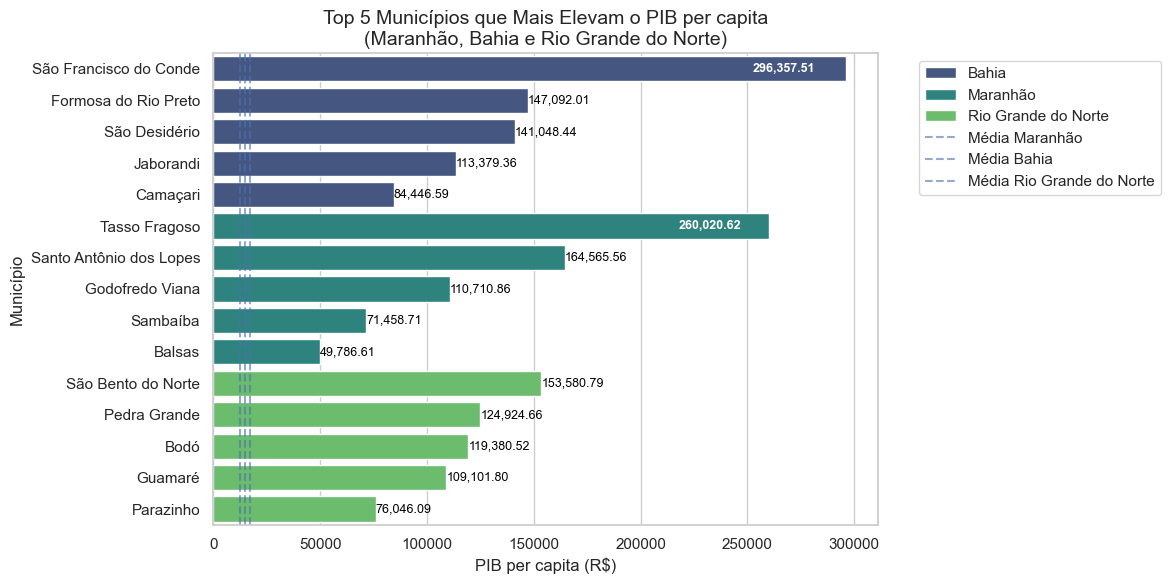

In [213]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')
plt.figure(figsize=(12, 6))
barplot = sns.barplot(
    x='PIB per capita', 
    y='Município', 
    hue='Estado', 
    data=df_top, 
    palette='viridis'
)

# Adicionar valores nas barras
for p in barplot.patches:
    valor = p.get_width()
    if valor > 0:
        if valor > df_top['PIB per capita'].max() * 0.85:
            barplot.annotate(
                f'{valor:,.2f}',
                (valor - (valor * 0.05), p.get_y() + p.get_height() / 2),
                ha='right', va='center',
                color='white', fontsize=9, weight='bold'
            )
        else:
            barplot.annotate(
                f'{valor:,.2f}',
                (valor, p.get_y() + p.get_height() / 2),
                ha='left', va='center',
                color='black', fontsize=9
            )

# Linha de média para cada estado
for estado in estados_desiguais:
    media = df_top[df_top['Estado'] == estado]['Média do estado'].iloc[0]
    plt.axvline(media, linestyle='--', label=f'Média {estado}', alpha=0.6)

plt.title('Top 5 Municípios que Mais Elevam o PIB per capita\n(Maranhão, Bahia e Rio Grande do Norte)', fontsize=14)
plt.xlabel('PIB per capita (R$)', fontsize=12)
plt.ylabel('Município', fontsize=12)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [214]:
df_uf_agrupado = df_nordeste.groupby('Nome_UF').sum(numeric_only=True).reset_index()
df_uf_agrupado['PIB per capita (UF)'] = (df_uf_agrupado['PIB (Mil Reais)'] * 1000) /df_uf_agrupado['População (Pessoas)']
df_uf_agrupado = df_uf_agrupado.drop(columns=['PIB per capita'])


In [215]:
df_uf_agrupado['% VA da agropecuária'] = ((df_uf_agrupado['VA da agropecuária (Mil Reais)']/df_uf_agrupado['PIB (Mil Reais)'])*100).round(2)
df_uf_agrupado['% VA da indústria'] = ((df_uf_agrupado['VA da indústria (Mil Reais)']/df_uf_agrupado['PIB (Mil Reais)'])*100).round(2)
df_uf_agrupado['% VA dos serviços'] = ((df_uf_agrupado['VA dos serviços (Mil Reais)']/df_uf_agrupado['PIB (Mil Reais)'])*100).round(2)
df_uf_agrupado['% VA da administração pública'] = ((df_uf_agrupado['VA da administração pública (Mil Reais)']/df_uf_agrupado['PIB (Mil Reais)'])*100).round(2)
df_uf_agrupado['% Impostos'] = ((df_uf_agrupado['Impostos (Mil Reais)']/df_uf_agrupado['PIB (Mil Reais)'])*100).round(2)

In [216]:
#df_nordeste_teste = df_nordeste.groupby(['Nome_Município'])['PIB per capita'].describe()
df_nordeste_teste

,count,mean,std,min,25%,50%,75%,max,coef_variacao
Nome_UF,,,,,,,,,
Maranhão,217.0,12469.984085,22230.900674,4924.029824,6985.610552,8022.925095,10454.239092,260020.624563,178.28
Bahia,417.0,14718.686529,19782.901746,6217.444797,8621.412037,10636.552201,13704.371851,296357.510250,134.41
Rio Grande do Norte,167.0,17312.085158,19136.145405,8069.878345,10351.992622,12115.608108,16190.413387,153580.787633,110.54
Pernambuco,185.0,13597.080376,13406.616301,6517.159309,8569.627836,10605.875153,13537.371103,139391.956506,98.60
Piauí,224.0,13484.865672,12936.916976,7026.198652,8827.227429,9904.479783,11604.744722,105367.320709,95.94
Alagoas,102.0,16874.788528,14253.248997,6958.093673,10540.480132,13385.047324,18673.473587,129102.648077,84.46
Sergipe,75.0,16220.558406,11509.882723,9318.468702,11549.530207,13627.631157,16802.895309,103993.289915,70.96
Paraíba,223.0,11685.011823,7840.521714,7340.892330,8970.610615,10199.226306,11729.765515,111427.130329,67.10
Ceará,184.0,12504.510638,8043.999133,6695.223037,8673.445125,10444.428185,13215.399689,83473.122020,64.33


**Medidas de tendência central e dispersão PIB per capita**

# Gráficos

C:\Users\carlo\AppData\Local\Temp\ipykernel_18748\2942720834.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='coef_variacao', y='Nome_UF', data=df_cv, palette='viridis')


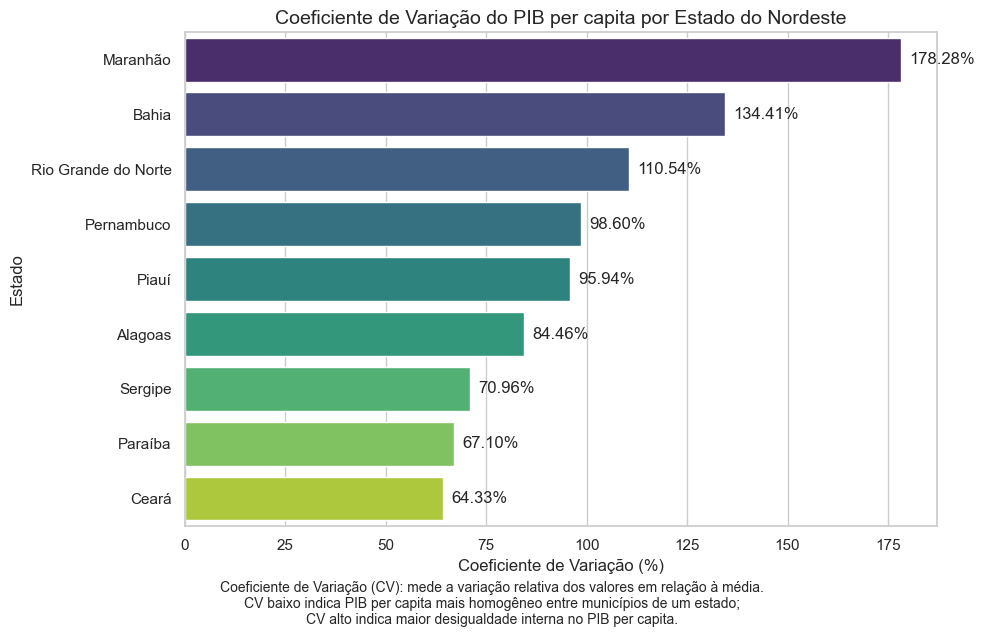

In [217]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_cv = pd.DataFrame(df_nordeste_teste['coef_variacao'])
df_cv = df_cv.reset_index()

sns.set_theme(style='whitegrid')

plt.figure(figsize=(10,6))
barplot = sns.barplot(x='coef_variacao', y='Nome_UF', data=df_cv, palette='viridis')

plt.title('Coeficiente de Variação do PIB per capita por Estado do Nordeste', fontsize=14)
plt.xlabel('Coeficiente de Variação (%)', fontsize=12)
plt.ylabel('Estado', fontsize=12)

for index, value in enumerate(df_cv['coef_variacao']):
    plt.text(value + 2, index, f'{value:.2f}%', va='center')

# Adiciona legenda explicativa embaixo do gráfico
plt.figtext(0.5, -0.05, 
            "Coeficiente de Variação (CV): mede a variação relativa dos valores em relação à média.\n"
            "CV baixo indica PIB per capita mais homogêneo entre municípios de um estado;\n"
            "CV alto indica maior desigualdade interna no PIB per capita.", 
            wrap=True, horizontalalignment='center', fontsize=10)

plt.tight_layout()
plt.show()


In [218]:
#estado
df_ordenado = df_uf_agrupado.sort_values(by='PIB per capita (UF)', ascending=False)
top3 = df_ordenado.head(3)

In [219]:
bottom3 = df_ordenado.tail(3)

In [220]:
# Medidas de tendência central
media = df_ordenado['PIB per capita (UF)'].mean()
mediana = df_ordenado['PIB per capita (UF)'].median()
moda = df_ordenado['PIB per capita (UF)'].mode()[0]  # Se existir mais de uma, pega a primeira

# Medidas de dispersão
desvio_padrao =df_ordenado['PIB per capita (UF)'].std()
variancia =df_ordenado['PIB per capita (UF)'].var()
amplitude =df_ordenado['PIB per capita (UF)'].max() -df_ordenado['PIB per capita (UF)'].min()
q1 =df_ordenado['PIB per capita (UF)'].quantile(0.25)
q3 =df_ordenado['PIB per capita (UF)'].quantile(0.75)
iqr = q3 - q1

C:\Users\carlo\AppData\Local\Temp\ipykernel_18748\2042758496.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(ax=axes[0], x='PIB per capita (UF)', y='Nome_UF', data=top3, palette='Greens_r')
C:\Users\carlo\AppData\Local\Temp\ipykernel_18748\2042758496.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(ax=axes[1], x='PIB per capita (UF)', y='Nome_UF', data=bottom3, palette='Reds')


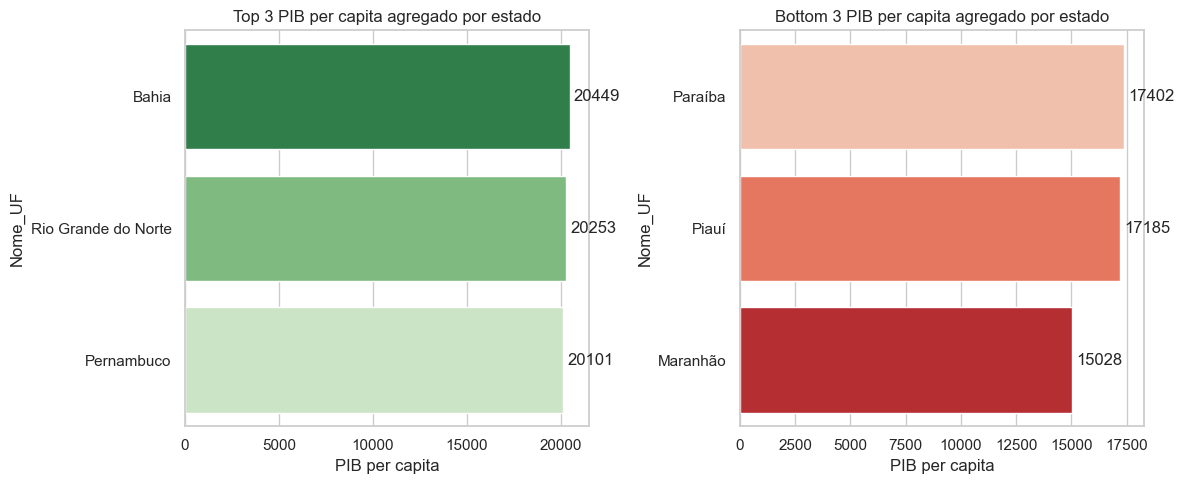

In [221]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Top 3
ax1 = sns.barplot(ax=axes[0], x='PIB per capita (UF)', y='Nome_UF', data=top3, palette='Greens_r')
axes[0].set_title('Top 3 PIB per capita agregado por estado')
axes[0].set_xlabel('PIB per capita')

# Adiciona labels com valores nas barras
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.0f', padding=3)  # sem casas decimais, com espaçamento

# Bottom 3
ax2 = sns.barplot(ax=axes[1], x='PIB per capita (UF)', y='Nome_UF', data=bottom3, palette='Reds')
axes[1].set_title('Bottom 3 PIB per capita agregado por estado')
axes[1].set_xlabel('PIB per capita')

for container in ax2.containers:
    ax2.bar_label(container, fmt='%.0f', padding=3)

plt.tight_layout()
plt.show()


In [222]:
#minicipio
df_ordenado_1 = df_nordeste.sort_values(by='PIB per capita', ascending=False)
top5 = df_ordenado_1.head(5)

In [223]:
bottom5 = df_ordenado_1.tail(5)


In [224]:
filtro_top3 = df_nordeste[df_nordeste['Nome_UF'].isin(['Bahia','Rio Grande do Norte','Pernambuco'])]
filtro_ba = df_nordeste[df_nordeste['Nome_UF'].isin(['Bahia'])]
filtro_rn = df_nordeste[df_nordeste['Nome_UF'].isin(['Rio Grande do Norte'])]
filtro_pe = df_nordeste[df_nordeste['Nome_UF'].isin(['Pernambuco'])]


In [225]:
# Lista dos estados no filtro
estados = ['Bahia', 'Rio Grande do Norte', 'Pernambuco']

for estado in estados:
    dados_estado = df_nordeste[df_nordeste['Nome_UF'] == estado]['PIB per capita']

    # Medidas de tendência central
    media = dados_estado.mean()
    mediana = dados_estado.median()
    moda = dados_estado.mode()[0] if not dados_estado.mode().empty else None

    # Medidas de dispersão
    desvio_padrao = dados_estado.std()
    variancia = dados_estado.var()
    amplitude = dados_estado.max() - dados_estado.min()
    q1 = dados_estado.quantile(0.25)
    q3 = dados_estado.quantile(0.75)
    coef_variacao = (desvio_padrao / media) * 100 if media != 0 else None
    iqr = q3 - q1

C:\Users\carlo\AppData\Local\Temp\ipykernel_18748\1607608870.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='PIB per capita', y='Município_x', data=top5, palette='Greens_r')


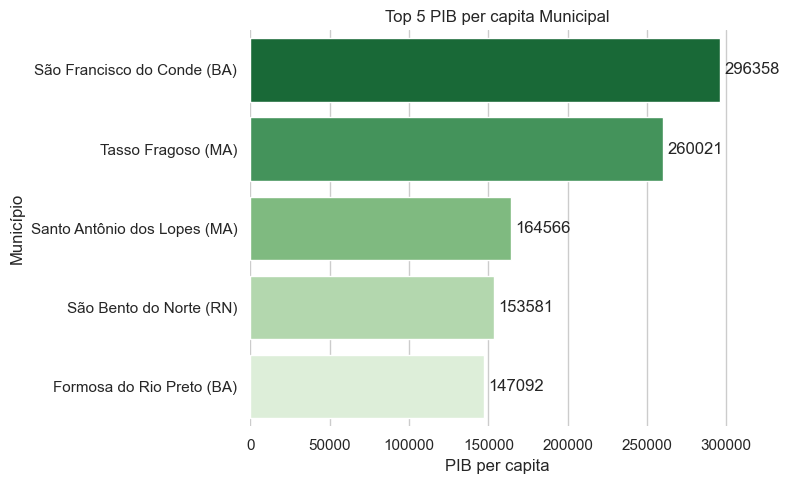

In [226]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.set_style("whitegrid")

ax = sns.barplot(x='PIB per capita', y='Município_x', data=top5, palette='Greens_r')
ax.set_title('Top 5 PIB per capita Municipal')
ax.set_xlabel('PIB per capita')
ax.set_ylabel('Município')

# Adiciona os valores na barra
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', padding=3)

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()


C:\Users\carlo\AppData\Local\Temp\ipykernel_18748\76440574.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='PIB per capita', y='Município_x', data=bottom5, palette='Reds')


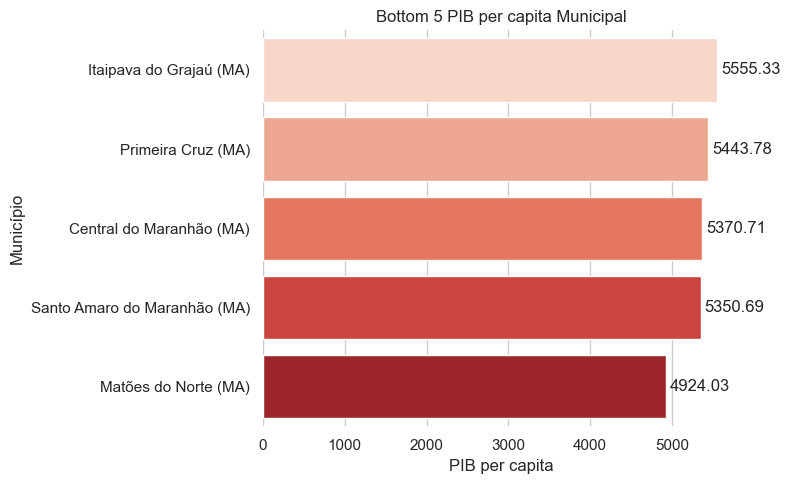

In [227]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.set_style("whitegrid")

ax = sns.barplot(x='PIB per capita', y='Município_x', data=bottom5, palette='Reds')
ax.set_title('Bottom 5 PIB per capita Municipal')
ax.set_xlabel('PIB per capita')
ax.set_ylabel('Município')

# Adiciona os valores na barra
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()


In [228]:
df_ordenado_2 = df_nordeste.sort_values(by='PIB (Mil Reais)', ascending=False)


C:\Users\carlo\AppData\Local\Temp\ipykernel_18748\1587299148.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='PIB (Mil Reais)', y='Município_x', data=df_ordenado_2.head(5), palette='Greens_r')


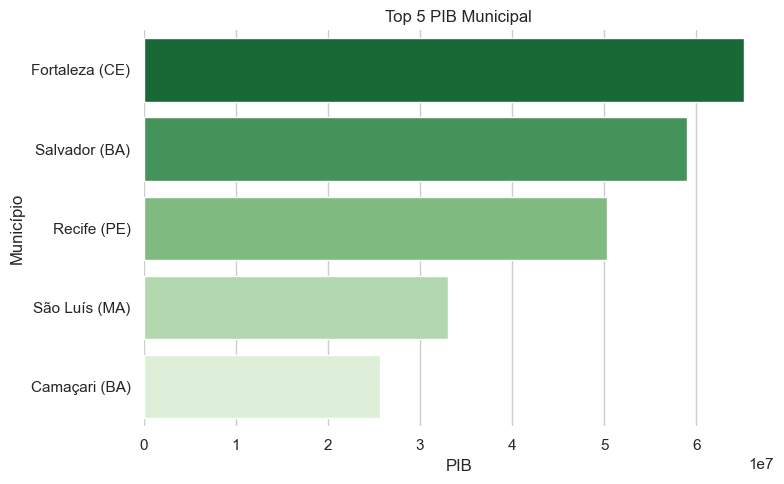

In [229]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.set_style("whitegrid")  # estilo mais clean, com grid suave

# Gráfico Top 5
ax = sns.barplot(x='PIB (Mil Reais)', y='Município_x', data=df_ordenado_2.head(5), palette='Greens_r')
ax.set_title('Top 5 PIB Municipal')
ax.set_xlabel('PIB')
ax.set_ylabel('Município')

# Remove bordas (spines)
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()


C:\Users\carlo\AppData\Local\Temp\ipykernel_18748\1884532643.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='PIB (Mil Reais)', y='Município_x', data=df_ordenado_2.tail(5), palette='Reds')


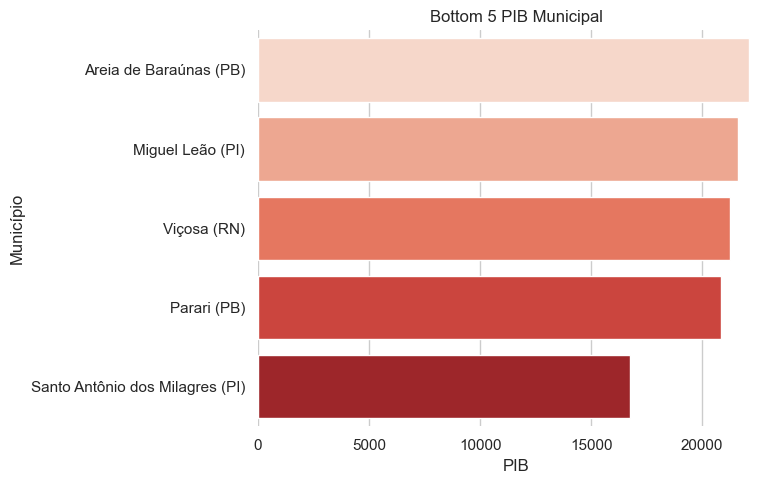

In [230]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.set_style("whitegrid")  # estilo mais clean, com grid suave

# Gráfico Top 5
ax = sns.barplot(x='PIB (Mil Reais)', y='Município_x', data=df_ordenado_2.tail(5), palette='Reds')
ax.set_title('Bottom 5 PIB Municipal')
ax.set_xlabel('PIB')
ax.set_ylabel('Município')

# Remove bordas (spines)
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()

C:\Users\carlo\AppData\Local\Temp\ipykernel_18748\488982086.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='PIB (Mil Reais)', y='Município_x', data=top5, palette='Greens_r')


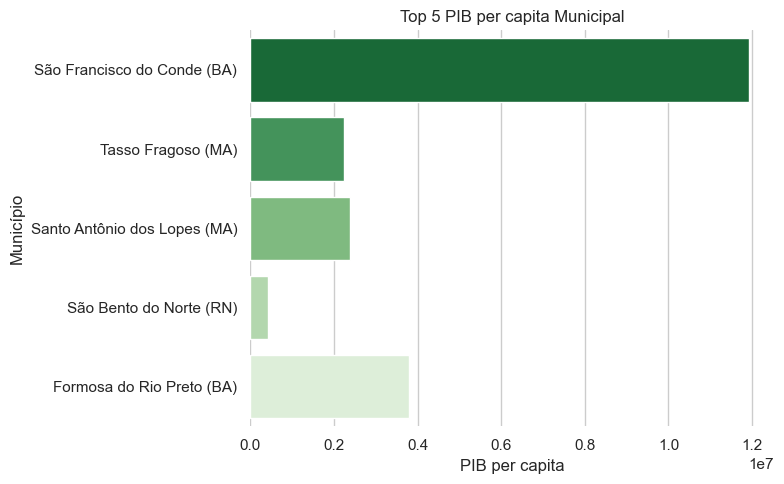

In [231]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.set_style("whitegrid")  # estilo mais clean, com grid suave

# Gráfico Top 5
ax = sns.barplot(x='PIB (Mil Reais)', y='Município_x', data=top5, palette='Greens_r')
ax.set_title('Top 5 PIB per capita Municipal')
ax.set_xlabel('PIB per capita')
ax.set_ylabel('Município')

# Remove bordas (spines)
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()

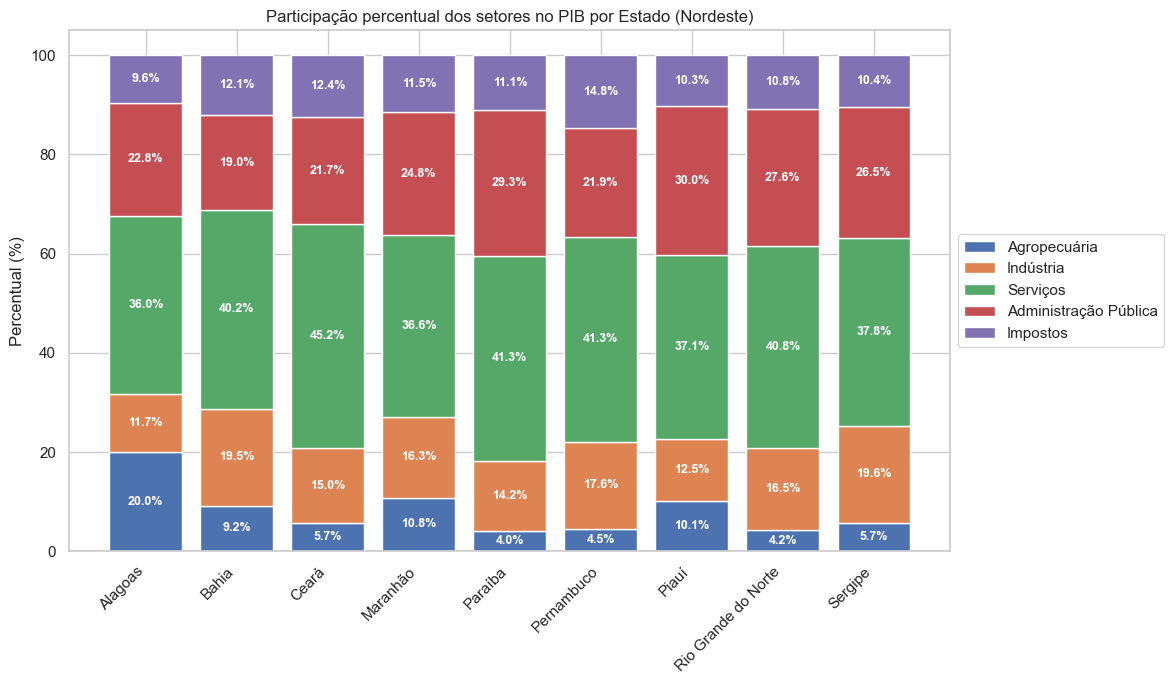

In [232]:
import numpy as np
import matplotlib.pyplot as plt

estados = df_uf_agrupado['Nome_UF']
pib = df_uf_agrupado['PIB (Mil Reais)']
impostos = df_uf_agrupado['Impostos (Mil Reais)']
agro = df_uf_agrupado['VA da agropecuária (Mil Reais)']
industria = df_uf_agrupado['VA da indústria (Mil Reais)']
servicos = df_uf_agrupado['VA dos serviços (Mil Reais)']
adm_publica = df_uf_agrupado['VA da administração pública (Mil Reais)']

total = pib.values

agro_pct = (agro / total) * 100
industria_pct = (industria / total) * 100
servicos_pct = (servicos / total) * 100
adm_publica_pct = (adm_publica / total) * 100
impostos_pct = (impostos / total) * 100

x = np.arange(len(estados))

fig, ax = plt.subplots(figsize=(14,7))

b1 = ax.bar(x, agro_pct, label='Agropecuária')
b2 = ax.bar(x, industria_pct, bottom=agro_pct, label='Indústria')
b3 = ax.bar(x, servicos_pct, bottom=agro_pct+industria_pct, label='Serviços')
b4 = ax.bar(x, adm_publica_pct, bottom=agro_pct+industria_pct+servicos_pct, label='Administração Pública')
b5 = ax.bar(x, impostos_pct, bottom=agro_pct+industria_pct+servicos_pct+adm_publica_pct, label='Impostos')

ax.set_xticks(x)
ax.set_xticklabels(estados, rotation=45, ha='right')
ax.set_ylabel('Percentual (%)')
ax.set_title('Participação percentual dos setores no PIB por Estado (Nordeste)')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

def add_labels(barras):
    for barra in barras:
        altura = barra.get_height()
        if altura > 3:
            ax.text(barra.get_x() + barra.get_width()/2, barra.get_y() + altura/2,
                    f'{altura:.1f}%', ha='center', va='center', color='white', fontsize=9, fontweight='bold')

add_labels(b1)
add_labels(b2)
add_labels(b3)
add_labels(b4)
add_labels(b5)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

In [233]:
df_nordeste["PIB per capita"].skew()

np.float64(8.66433441335063)

**Assimetria** é uma medida de "inclinação" dos valores em relação a sua média.
**assimetria positiva:** indica que a causa está a direita

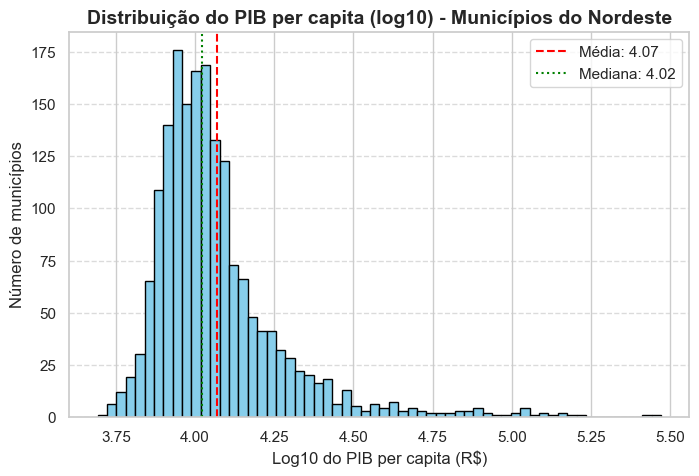

In [234]:
import matplotlib.pyplot as plt
import numpy as np

# Cria o histograma do PIB per capita (municípios do Nordeste) com log
plt.figure(figsize=(8,5))
plt.hist(np.log10(df_nordeste["PIB per capita"]), bins=60, color="skyblue", edgecolor="black")

# Títulos e rótulos ajustados
plt.title("Distribuição do PIB per capita (log10) - Municípios do Nordeste", fontsize=14, fontweight="bold")
plt.xlabel("Log10 do PIB per capita (R$)", fontsize=12)
plt.ylabel("Número de municípios", fontsize=12)

# Média e mediana no gráfico
media = np.mean(np.log10(df_nordeste["PIB per capita"]))
mediana = np.median(np.log10(df_nordeste["PIB per capita"]))
plt.axvline(media, color='red', linestyle='--', label=f"Média: {media:.2f}")
plt.axvline(mediana, color='green', linestyle=':', label=f"Mediana: {mediana:.2f}")

plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()



````
Cada barra representa uma faixa de PIB per capita (em escala logarítmica).
O eixo Y mostra quantos municípios estão naquela faixa.
Ao usar o log10 do PIB per capita, nós transformamos valores que iam de alguns poucos reais por pessoa até centenas de milhares em uma escala mais compacta e interpretável.

Interpretação: A distribuição é fortemente assimétrica (cauda longa à direita). O log(10) suaviza essa assimetria, tornando o padrão mais claro.
Existem alguns poucos municípios com PIB per capita altíssimo (outliers).
A média é puxada para cima por esses outliers, ficando maior que a mediana.
````


In [235]:
df_nordeste["PIB per capita"].kurtosis()

np.float64(106.35798427831806)

In [236]:
df_nordeste["PIB (Mil Reais)"].kurtosis()

np.float64(263.30066599619386)

**Curtose**: Medida em relação a causa. 
Curtose elevada indica muitos outliers.

**Boxplot**: método gráfico para demonstrar localização, dispersão e asssimetria de dados numéricos.

C:\Users\carlo\AppData\Local\Temp\ipykernel_18748\1044400208.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="PIB per capita", data=df_nordeste, palette="Set2", whis=10)


<Axes: xlabel='PIB per capita'>

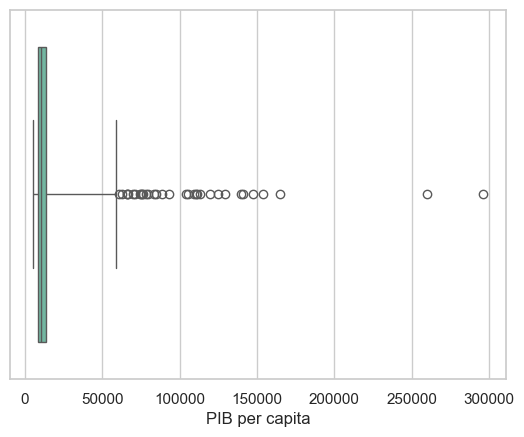

In [237]:
import seaborn as sns

sns.set_theme(style="whitegrid")
sns.boxplot(x="PIB per capita", data=df_nordeste, palette="Set2", whis=10)



In [238]:
q1=df_nordeste["PIB per capita"].quantile(0.25)
q3=df_nordeste["PIB per capita"].quantile(0.75)
m= df_nordeste["PIB per capita"].mean()
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr


C:\Users\carlo\AppData\Local\Temp\ipykernel_18748\974687786.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="PIB (Mil Reais)", data=df_nordeste, palette="Set2", whis=0.5)


<Axes: xlabel='PIB (Mil Reais)'>

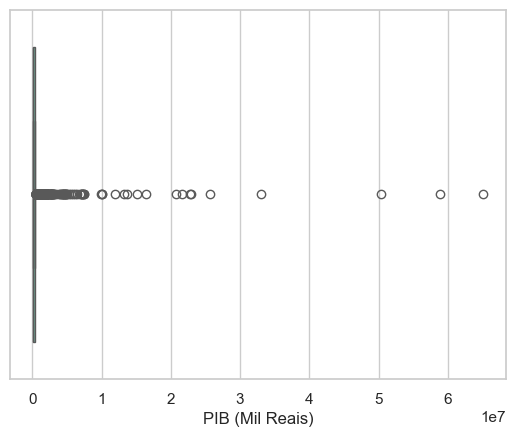

In [239]:
import seaborn as sns

sns.set_theme(style="whitegrid")
sns.boxplot(x="PIB (Mil Reais)", data=df_nordeste, palette="Set2", whis=0.5)


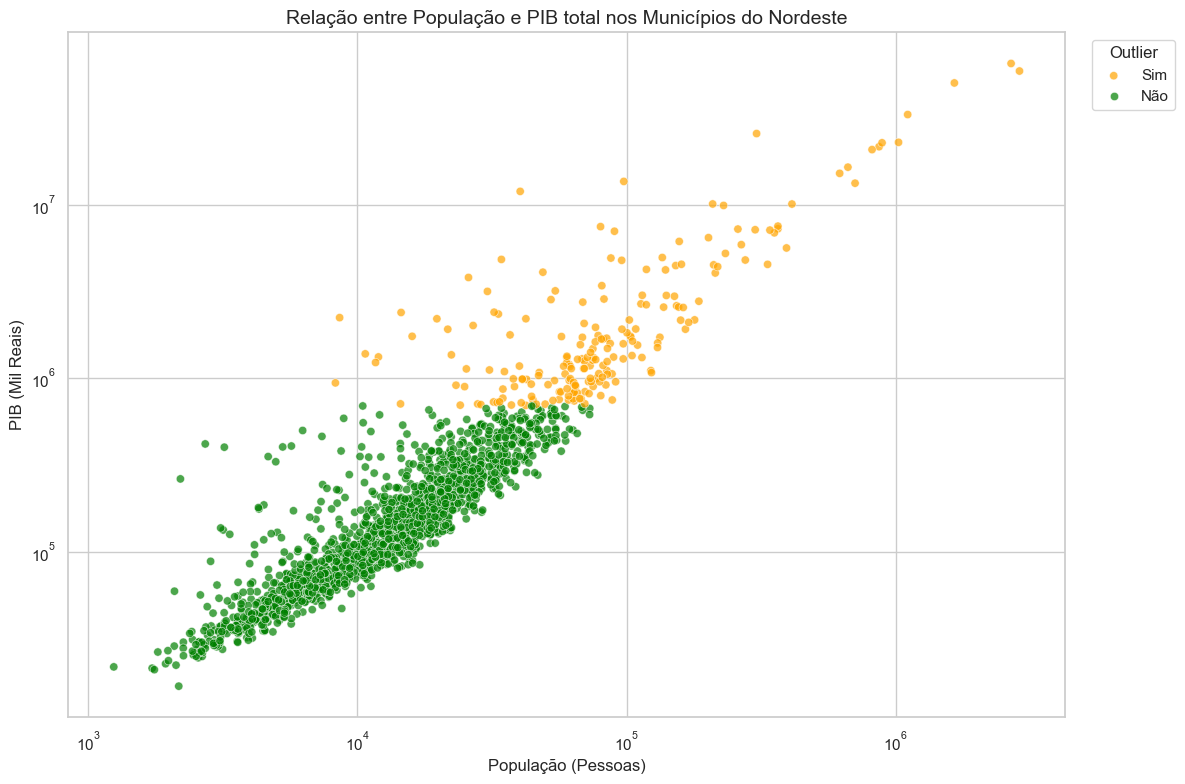

In [240]:
import matplotlib.pyplot as plt
import seaborn as sns

q1 = df_nordeste['PIB (Mil Reais)'].quantile(0.25)
q3 = df_nordeste['PIB (Mil Reais)'].quantile(0.75)
iqr = q3 - q1
limite_inferior = q1 - 1.5 * iqr
limite_superior = q3 + 1.5 * iqr
outliers = (df_nordeste['PIB (Mil Reais)'] < limite_inferior) | (df_nordeste['PIB (Mil Reais)'] > limite_superior)

plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_nordeste, x='População (Pessoas)', y='PIB (Mil Reais)', hue=outliers, palette={True: 'orange', False: 'green'}, alpha=0.7)

plt.title('Relação entre População e PIB total nos Municípios do Nordeste', fontsize=14)
plt.xlabel('População (Pessoas)')
plt.ylabel('PIB (Mil Reais)')
plt.xscale('log')
plt.yscale('log')
plt.legend(title='Outlier', labels=['Sim', 'Não'], bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


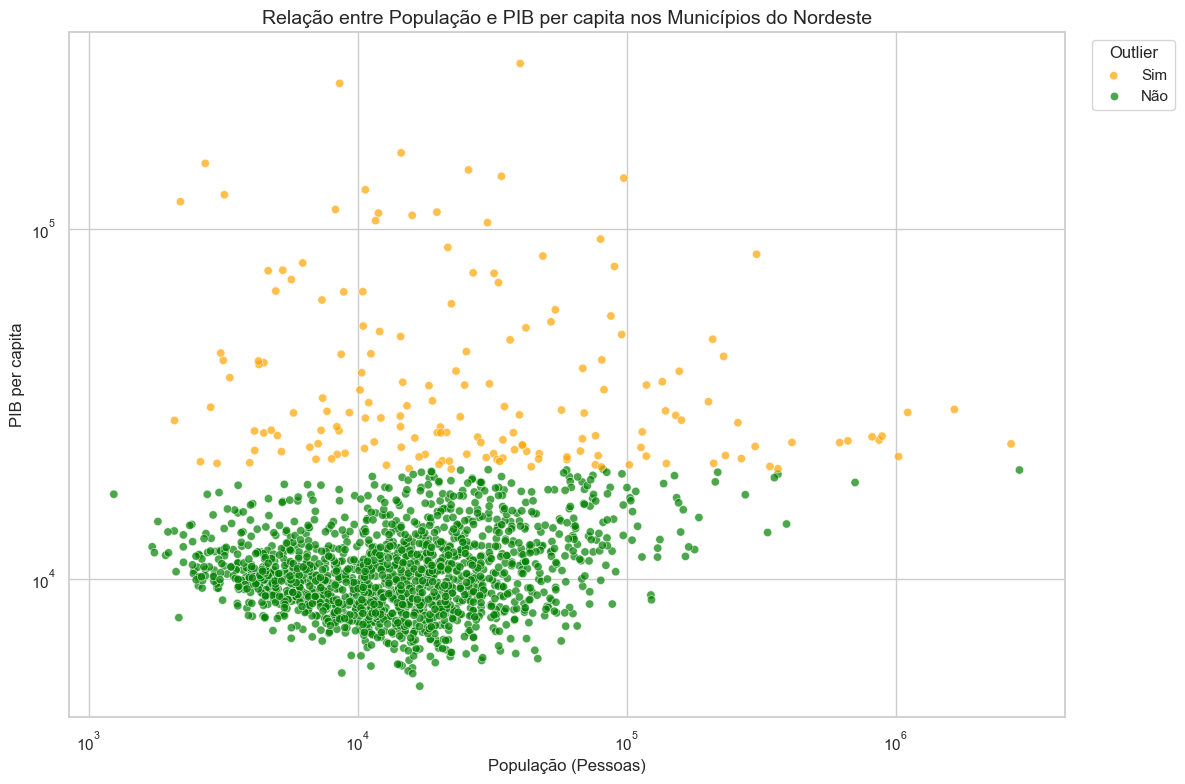

In [241]:
import matplotlib.pyplot as plt
import seaborn as sns

q1 = df_nordeste['PIB per capita'].quantile(0.25)
q3 = df_nordeste['PIB per capita'].quantile(0.75)
iqr = q3 - q1
limite_inferior = q1 - 1.5 * iqr
limite_superior = q3 + 1.5 * iqr
outliers = (df_nordeste['PIB per capita'] < limite_inferior) | (df_nordeste['PIB per capita'] > limite_superior)

plt.figure(figsize=(12, 8))
sns.scatterplot( data=df_nordeste, x='População (Pessoas)', y='PIB per capita', hue=outliers, palette={True: 'orange', False: 'green'}, alpha=0.7)

plt.title('Relação entre População e PIB per capita nos Municípios do Nordeste', fontsize=14)
plt.xlabel('População (Pessoas)')
plt.ylabel('PIB per capita')
plt.xscale('log')
plt.yscale('log')
plt.legend(title='Outlier', labels=['Sim', 'Não'], bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [242]:
df_bahia=df_nordeste[df_nordeste['Nome_UF']=="Bahia"]

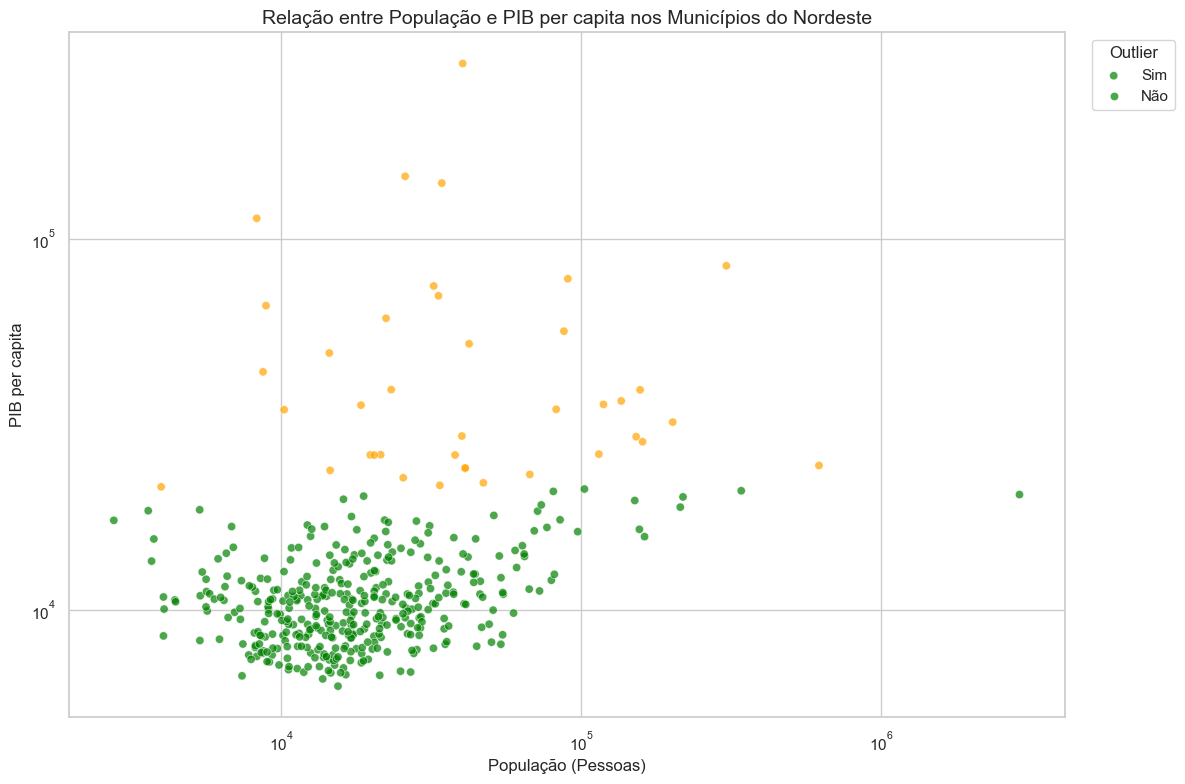

In [243]:
import matplotlib.pyplot as plt
import seaborn as sns

q1 = df_bahia['PIB per capita'].quantile(0.25)
q3 = df_bahia['PIB per capita'].quantile(0.75)
iqr = q3 - q1
limite_inferior = q1 - 1.5 * iqr
limite_superior = q3 + 1.5 * iqr
outliers = (df_bahia['PIB per capita'] < limite_inferior) | (df_bahia['PIB per capita'] > limite_superior)

plt.figure(figsize=(12, 8))
sns.scatterplot( data=df_bahia, x='População (Pessoas)', y='PIB per capita', hue=outliers, palette={True: 'orange', False: 'green'}, alpha=0.7)

plt.title('Relação entre População e PIB per capita nos Municípios do Nordeste', fontsize=14)
plt.xlabel('População (Pessoas)')
plt.ylabel('PIB per capita')
plt.xscale('log')
plt.yscale('log')
plt.legend(title='Outlier', labels=['Sim', 'Não'], bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [244]:
import numpy as np

df_nordeste["LOG10 Pib Per Capta"] = (np.log10(df_nordeste["PIB per capita"]))

C:\Users\carlo\AppData\Local\Temp\ipykernel_18748\1243618892.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="LOG10 Pib Per Capta", data=df_nordeste, palette="Set2", whis=0.5)


<Axes: xlabel='LOG10 Pib Per Capta'>

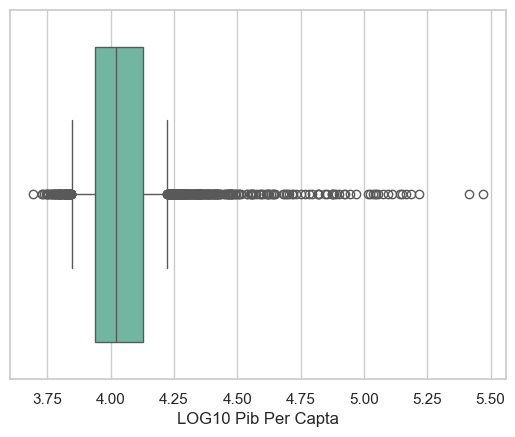

In [245]:
import seaborn as sns

sns.set_theme(style="whitegrid")
sns.boxplot(x="LOG10 Pib Per Capta", data=df_nordeste, palette="Set2", whis=0.5)



In [246]:
data = df_nordeste[df_nordeste["Nome_UF"] == "Maranhão"]

data["LOG10 Pib Per Capita"] = (np.log10(data["PIB per capita"]))


C:\Users\carlo\AppData\Local\Temp\ipykernel_18748\1958314306.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["LOG10 Pib Per Capita"] = (np.log10(data["PIB per capita"]))


C:\Users\carlo\AppData\Local\Temp\ipykernel_18748\2839957590.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="LOG10 Pib Per Capita", data=data, palette="Set2", whis=0.5)


<Axes: xlabel='LOG10 Pib Per Capita'>

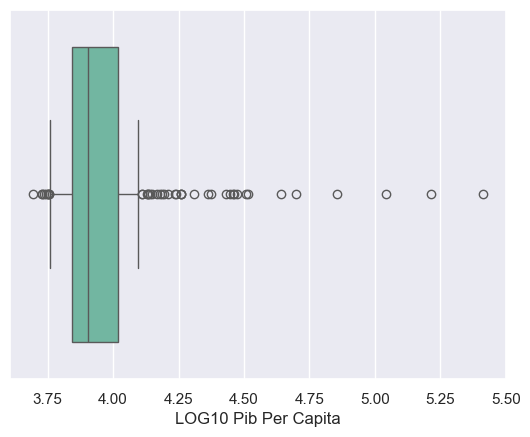

In [247]:

import seaborn as sns

sns.set_theme(style="darkgrid")
sns.boxplot(x="LOG10 Pib Per Capita", data=data, palette="Set2", whis=0.5)




In [248]:
data = df_nordeste[df_nordeste["Nome_UF"] == "Ceará"]

data["LOG10 Pib Per Capita"] = (np.log10(data["PIB per capita"]))


C:\Users\carlo\AppData\Local\Temp\ipykernel_18748\454859896.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["LOG10 Pib Per Capita"] = (np.log10(data["PIB per capita"]))


C:\Users\carlo\AppData\Local\Temp\ipykernel_18748\1144132207.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="LOG10 Pib Per Capita", data=data, palette="Set2", whis=0.5)


<Axes: xlabel='LOG10 Pib Per Capita'>

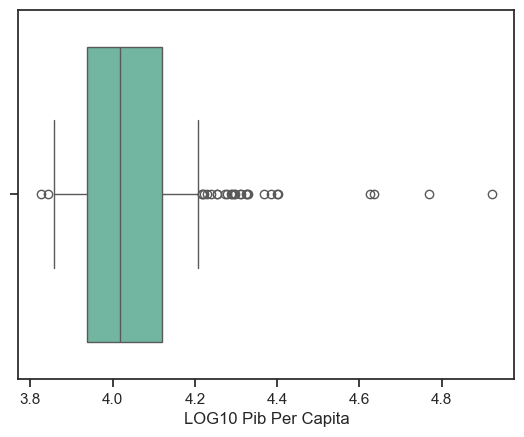

In [249]:

import seaborn as sns

sns.set_theme(style="ticks")
sns.boxplot(x="LOG10 Pib Per Capita", data=data, palette="Set2", whis=0.5)

